In [2]:
import numpy as np
import matplotlib.pyplot as plt

Install and import `causaltensor` package

In [3]:
!pip install causaltensor #install the causaltensor package
import causaltensor as ct

## Data Generation

In [7]:
from causaltensor.matlib import low_rank_M0_normal
from causaltensor.matlib import iid_treatment

n1 = 100
n2 = 100
r = 2
M0 = low_rank_M0_normal(n1 = n1, n2 = n2, r = r) #low rank baseline matrix

num_treat = 5 #number of treatments
prob = 0.2
Z = []
tau = []
for k in range(num_treat):
    Z.append(iid_treatment(prob=prob, shape=M0.shape)) #treatment patterns
    tau.append(np.random.normal(loc=0, scale=1)) #treatment effects

## Empirical Experiments

In [13]:
def adding_noise(M0, Z, tau, Sigma, SigmaZ):
    num_treat = len(Z)
    O = M0 + np.random.normal(loc=0, scale=1, size=M0.shape) * Sigma #add heterogenous noise to the baseline matrix
    for k in range(num_treat):
        O += Z[k] * tau[k] + Z[k] * SigmaZ[k] * np.random.normal(loc=0, scale=1, size=M0.shape) #add heterogeneous noise to the treatment effects
    return O

In [14]:
from causaltensor.cauest import non_convex_panel_regression

Sigma = np.random.rand(M0.shape[0], M0.shape[1])
SigmaZ = []
for k in range(num_treat):
    SigmaZ.append(np.random.rand(M0.shape[0], M0.shape[1]))

results = []
for T in range(1000):
    O = adding_noise(M0, Z, tau, Sigma, SigmaZ)
    M, tau_hat = non_convex_panel_regression(O, Z, r=r) #solving a non-convex optimization to obtain M and tau
    results.append(tau_hat)
results = np.array(results)

In [15]:
print('the estimated effect ', np.mean(results, axis=0)) #the mean of the estimated treatment effects
print('the true effect ', tau) #the true treatment effects

the estimated effect  [ 0.53821599 -1.25691476  0.18771391 -0.11386221  0.98543392]
the true effect  [0.53814186498851, -1.2567108785919663, 0.1880640045830144, -0.11375866144894219, 0.9855216946172819]


### Empirical distribution of the estimated treatment effects (each sample has a different realization of noises)
The plot is obtained over 10000 samples (it cost ~5 minutes in a Macbook Pro)

the empirical standard deviation 0.02274766006767708


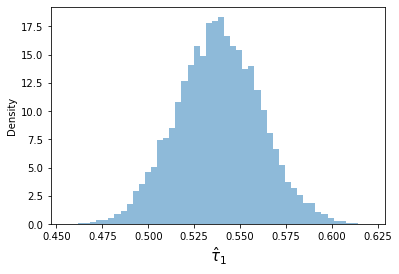

In [38]:
_ = plt.hist(results[:, 0], bins=50, density=True, alpha=0.5, label='Empirical Data')
plt.xlabel(r'$\hat{\tau}_1$', fontsize=15)
plt.ylabel('Density')
print('the empirical standard deviation', np.std(results[:, 0]))

### Compute the confidence interval given one sample

In [39]:
from causaltensor.cauest import projection_T_orthogonal
from causaltensor.cauest import panel_regression_CI


O = adding_noise(M0, Z, tau, Sigma, SigmaZ)
M, tau_hat = non_convex_panel_regression(O, Z, r=r)
E_hat = O - M
for k in range(num_treat):
    E_hat -= tau_hat[k] * Z[k]
CI = panel_regression_CI(M, Z, E_hat)
print('the estimated standard deviation is ', np.sqrt(CI[0, 0]))

the estimated standard deviation is  0.02229146804441463


### Comparing the computed confidence interval and empirical distribution

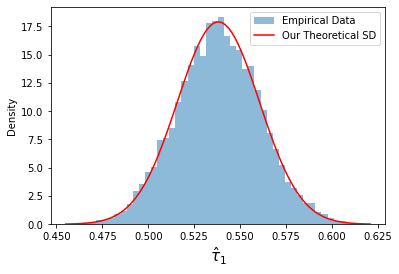

In [40]:
from scipy.stats import norm
data = results[:, 0]

# Define the Gaussian function
def gaussian(x, mean, std):
    return norm.pdf(x, loc=mean, scale=std)

# Generate x values for plotting
x = np.linspace(data.min(), data.max(), 100)

# Plot the empirical data
plt.hist(data, bins=50, density=True, alpha=0.5, label='Empirical Data')

# Plot the Gaussian fit
plt.plot(x, gaussian(x, tau[0], np.sqrt(CI[0, 0])), 'r-', label='Our Theoretical SD')

# Add labels and a legend
plt.xlabel(r'$\hat{\tau}_1$', fontsize=15)
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()